In [24]:
import os
import sys
import ast
from pprint import pprint
import pandas as pd
import matplotlib.pylab as plt

In [25]:
root = '/home/wmnlab/D/database'
paths = [s for s in os.listdir(root) if s.startswith('202')]

md_files = []

for date_dir in paths:
    datedir = os.path.join(root, date_dir)
    md_file = [os.path.join(datedir, s) for s in os.listdir(datedir) if s.endswith('.md')]
    md_files += md_file

md_files = sorted(md_files)

md_files = md_files[:-1]

pprint(md_files)

['/home/wmnlab/D/database/2023-03-16/2023-03-16.md',
 '/home/wmnlab/D/database/2023-03-26/2023-03-26.md',
 '/home/wmnlab/D/database/2023-04-01/2023-04-01.md',
 '/home/wmnlab/D/database/2023-04-10/2023-04-10.md',
 '/home/wmnlab/D/database/2023-04-17/2023-04-17.md',
 '/home/wmnlab/D/database/2023-05-04/2023-05-04.md',
 '/home/wmnlab/D/database/2023-05-07/2023-05-07.md',
 '/home/wmnlab/D/database/2023-05-15/2023-05-15.md',
 '/home/wmnlab/D/database/2023-05-24/2023-05-24.md']


In [26]:
class Experiment():
    
    def __init__(self, dir_name, setting):
        
        self.dir_name = dir_name
        self.setting = setting
        
    def __repr__(self):
        return f'{self.dir_name} -> {self.setting}'

exp_list = []

for md_file in md_files:
    
    md_f = open(md_file, 'r')
    lines = []
    l = md_f.readline()[:-1]
    
    while l:
        
        if l == '#endif':
            break
        lines.append(l)
        l = md_f.readline()[:-1]
        
    md_f.close()
    
    for exp, dic in zip(lines[::2], lines[1::2]):
        
        dictionary = ast.literal_eval(dic)
        parent_dir = os.path.dirname(md_file)
        experiment = Experiment(dir_name = os.path.join(parent_dir, exp), setting=dictionary)
        exp_list.append(experiment)
        
# pprint(exp_list)

In [27]:
# Set band parameters
schms = ['All', 'B3B7B8', 'B3', 'B7', 'B8', 'B3B7', 'B3B8', 'B7B8', 'LTE']

rrc_dict = {}
nr_dict = {}
lte_dict = {}
ul_pkt_dict = {}
dl_pkt_dict = {}

for schm in schms:
        
    path_list = []
    
    for exp in exp_list:
        
        reverse_dict = {v:k for k, v in exp.setting.items()}
        
        try: dev = reverse_dict[schm]
        except: continue
        
        device_dir = os.path.join(exp.dir_name, dev)
        
        for trace in os.listdir(device_dir):
        
            if '#' not in trace:
                continue
        
            trace_dir = os.path.join(device_dir, trace, 'data')
            path_list.append(trace_dir)

    path_list = sorted(path_list)

    rrc_list, nr_list, lte_list, ul_pkt_list, dl_pkt_list = [], [], [], [], []

    for path in path_list:
        
        rrc_list += [os.path.join(path, s) for s in os.listdir(path) if s.endswith('_rrc.csv')]
        nr_list += [os.path.join(path, s) for s in os.listdir(path) if s.endswith('_nr_ml1.csv')]
        lte_list += [os.path.join(path, s) for s in os.listdir(path) if s.endswith('_ml1.csv') and not s.endswith('_nr_ml1.csv')]
        ul_pkt_list += [os.path.join(path, s) for s in os.listdir(path) if s.endswith('udp_uplk_loss_latency.csv')]
        dl_pkt_list += [os.path.join(path, s) for s in os.listdir(path) if s.endswith('udp_dnlk_loss_latency.csv')]
    
    rrc_dict[schm] = rrc_list
    nr_dict[schm] = nr_list
    lte_dict[schm] = lte_list
    ul_pkt_dict[schm] = ul_pkt_list
    dl_pkt_dict[schm] = dl_pkt_list

rrc_dict['All'] = rrc_dict['All'] + rrc_dict['B3B7B8']
nr_dict['All'] = nr_dict['All'] + nr_dict['B3B7B8']
lte_dict['All'] = lte_dict['All'] + lte_dict['B3B7B8']
ul_pkt_dict['All'] = ul_pkt_dict['All'] + ul_pkt_dict['B3B7B8']
dl_pkt_dict['All'] = dl_pkt_dict['All'] + dl_pkt_dict['B3B7B8']

schms.remove('B3B7B8')

In [28]:
# dl_pkt_dict

# Box Plot

In [29]:
def set_data(df, mode='pcap', tz=0):
    if mode == 'pcap':
        df['seq'] = df['seq'].astype('Int32')
        # df['rpkg'] = df['rpkg'].astype('Int8')
        df['frame_id'] = df['frame_id'].astype('Int32')
        df['Timestamp'] = pd.to_datetime(df['Timestamp'])
        df['xmit_time'] = pd.to_datetime(df['xmit_time'])
        df['arr_time'] = pd.to_datetime(df['arr_time'])
        df['Timestamp_epoch'] = df['Timestamp_epoch'].astype('float32')
        df['xmit_time_epoch'] = df['xmit_time_epoch'].astype('float32')
        df['arr_time_epoch'] = df['arr_time_epoch'].astype('float32')
        df['lost'] = df['lost'].astype('boolean')
        df['excl'] = df['excl'].astype('boolean')
        df['latency'] = df['latency'].astype('float32')
    # E-UTRA & NR
    def nr_serv_cel(row):
        pos = row.serv_cel_pos
        if pos == 255:
            return 65535, -160, -50
        else:
            return row[f'PCI{pos}'], row[f'RSRP{pos}'], row[f'RSRQ{pos}']
    if mode == 'lte':
        df = df.rename(columns={
            'RSRP(dBm)': 'RSRP',
            'RSRQ(dB)': 'RSRQ',
            'Serving Cell Index': 'serv_cel_index',
            'Number of Neighbor Cells': 'num_neigh_cels',
            'Number of Detected Cells': 'num_cels',
            }).reindex(['Timestamp','type_id','PCI','RSRP','RSRQ','serv_cel_index','EARFCN','NR_ARFCN',
                        'num_cels','num_neigh_cels','serv_cel_pos','PCI0','RSRP0','RSRQ0',
                        *df.columns.to_list()[df.columns.get_loc('PCI1'):]], axis=1)
        df.loc[df['serv_cel_index'] == '(MI)Unknown', 'serv_cel_index'] = '3_SCell'
        df['num_cels'] = df['num_neigh_cels'] + 1
        ## set dtypes
        df['Timestamp'] = pd.to_datetime(df['Timestamp']) + pd.Timedelta(hours=tz)
        df['type_id'] = df['type_id'].astype('category')
        df['serv_cel_index'] = df['serv_cel_index'].astype('category')
        df['EARFCN'] = df['EARFCN'].astype('Int32')
        df['NR_ARFCN'] = df['NR_ARFCN'].astype('Int32')
        df['num_cels'] = df['num_cels'].astype('UInt8')
        df['num_neigh_cels'] = df['num_neigh_cels'].astype('UInt8')
        df['serv_cel_pos'] = df['serv_cel_pos'].astype('UInt8')
        for tag in df.columns:
            if tag.startswith('PCI'):
                df[tag] = df[tag].astype('Int32')
            if tag.startswith(('RSRP','RSRQ')):
                df[tag] = df[tag].astype('float32')
    if mode == 'nr':
        if df.empty:
            df = pd.DataFrame(columns=['Timestamp','type_id','PCI','RSRP','RSRQ','serv_cel_index','EARFCN','NR_ARFCN',
                                       'num_cels','num_neigh_cels','serv_cel_pos','PCI0','RSRP0','RSRQ0'])
        else:
            df = df.rename(columns={
                'Raster ARFCN': 'NR_ARFCN',
                'Serving Cell Index': 'serv_cel_pos',
                'Num Cells': 'num_cels',
                }).reindex(['Timestamp','type_id','PCI','RSRP','RSRQ','serv_cel_index','EARFCN','NR_ARFCN',
                            'num_cels','num_neigh_cels','serv_cel_pos','PCI0','RSRP0','RSRQ0',
                            *df.columns.to_list()[df.columns.get_loc('PCI1'):]], axis=1)
            df.loc[df['serv_cel_pos'] != 255, 'serv_cel_index'] = 'PSCell'
            df[['PCI','RSRP','RSRQ']] = df.apply(nr_serv_cel, axis=1, result_type='expand')
            df.loc[df['serv_cel_pos'] == 255, 'num_neigh_cels'] = df['num_cels']
            df.loc[df['serv_cel_pos'] != 255, 'num_neigh_cels'] = df['num_cels'] - 1
        ## set dtypes
        df['Timestamp'] = pd.to_datetime(df['Timestamp']) + pd.Timedelta(hours=tz)
        df['type_id'] = df['type_id'].astype('category')
        df['serv_cel_index'] = df['serv_cel_index'].astype('category')
        df['EARFCN'] = df['EARFCN'].astype('Int32')
        df['NR_ARFCN'] = df['NR_ARFCN'].astype('Int32')
        df['num_cels'] = df['num_cels'].astype('UInt8')
        df['num_neigh_cels'] = df['num_neigh_cels'].astype('UInt8')
        df['serv_cel_pos'] = df['serv_cel_pos'].astype('UInt8')
        for tag in df.columns:
            if tag.startswith('PCI'):
                df[tag] = df[tag].astype('Int32')
            if tag.startswith(('RSRP','RSRQ')):
                df[tag] = df[tag].astype('float32')
    return df

In [30]:
DD = {key: [0, []] for key in schms}

for schm in schms:

    dl_files = dl_pkt_dict[schm]

    for dl_file in dl_files:

        df_dl = pd.read_csv(dl_file)
        df_dl = set_data(df_dl)
        dlplr = df_dl.lost.mean() * 100
        
        print(round(dlplr, 2))
        
        DD[schm][0] += 1
        DD[schm][1].append(dlplr)

0.3
0.42
0.52
0.49
1.01
0.13
0.22
1.94
1.69
1.79
0.32
1.59
0.14
1.79
0.49
0.93
0.14
0.98
0.8
0.27
0.15
0.53
1.09
0.7
0.76
1.67
0.57
1.54
0.5
0.48
0.17
0.25
0.07
0.19
0.92
1.12
0.25
0.74
2.09
1.0
0.49
0.87
0.48
1.55
0.52
1.54
0.53
0.38
2.23
0.28
0.4
0.1
1.15
0.37
0.33
0.13
0.15
0.26
0.77
0.42
0.93
0.06
0.79
0.39
0.8
0.78
0.57
1.07
1.17
0.12
0.86
0.04
1.4
1.93
0.68
0.63
0.41
0.34
1.16
0.07
0.0
0.52
1.0
0.58
0.0
0.43
0.74
0.95
0.0
0.96
0.0
0.21
0.89
1.3
0.3
1.95
1.03
0.69
0.52
0.93
0.14
0.38
0.2
0.97
0.15
2.21
1.04
1.2
1.72
1.27
0.65
1.98
1.08
2.28
2.67
1.65
0.91
1.54
0.67
1.3
0.41
0.78
0.9
1.32
0.96
1.76
1.72
2.16
0.18
2.0
0.58
2.69
0.0
0.12
0.22
0.0
0.83
0.05
0.95
0.54
0.0
0.74
1.26
0.82
0.0
0.65
1.08
0.7
0.81
1.36
1.57
0.22
1.61
0.25
1.44
0.88
3.08
0.94
0.19
0.1
0.35
1.04
0.9
1.71
0.28
0.1
0.0
0.09
1.85
0.28
1.97
0.34
0.8
0.06
0.41
0.51
0.3
0.56
0.0
0.18
2.15
0.91
1.02
0.0
0.0
0.0
0.83
0.14
0.0
0.71
0.0
0.12
0.11
0.08
0.0
0.22
0.29
0.89
0.11
0.92
0.53
0.01
0.27
0.17
0.06
1.13
0.4
0.56


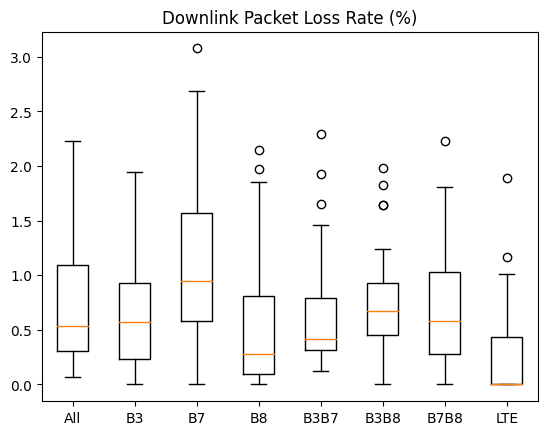

In [31]:
# Downlink
boxes = [DD[schm][1] for schm in schms]
labels = schms
plt.figure()
plt.boxplot(boxes, labels=labels, showfliers=True)
plt.title('Downlink Packet Loss Rate (%)')
plt.show()

In [32]:
numbers = [DD[schm][0] for schm in schms]
print(numbers)

[53, 51, 53, 51, 29, 29, 31, 51]
